# DS702 Flight Delay and Cancellation Analysis

#### Environment Set-Up

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!pip install -q findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=ae1abbbcfd114ba137d478c50e041142c885d09ada35b8bce3941bb8e905fb3b
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
!wget http://apache.osuosl.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar -xzvf spark-3.4.0-bin-hadoop3.tgz

--2023-04-27 11:13:17--  http://apache.osuosl.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 140.211.166.134, 64.50.233.100, 64.50.236.52, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|140.211.166.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388407094 (370M) [application/x-gzip]
Saving to: ‘spark-3.4.0-bin-hadoop3.tgz’

spark-3.4.0-bin-had 100%[===================>] 370.41M  38.4MB/s    in 35s     

2023-04-27 11:13:52 (10.6 MB/s) - ‘spark-3.4.0-bin-hadoop3.tgz’ saved [388407094/388407094]

spark-3.4.0-bin-hadoop3/
spark-3.4.0-bin-hadoop3/data/
spark-3.4.0-bin-hadoop3/data/streaming/
spark-3.4.0-bin-hadoop3/data/streaming/AFINN-111.txt
spark-3.4.0-bin-hadoop3/data/graphx/
spark-3.4.0-bin-hadoop3/data/graphx/followers.txt
spark-3.4.0-bin-hadoop3/data/graphx/users.txt
spark-3.4.0-bin-hadoop3/data/mllib/
spark-3.4.0-bin-hadoop3/data/mllib/als/
spark-3.4.0-bin-hadoop3/data/mllib/als/test.data
sp

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/MBZUAI/DS702/Project

/content/drive/My Drive/MBZUAI/DS702/Project


## Analysis Section

In [ ]:
#neccessary imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, desc, asc, corr, avg, min, max, floor, count
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pyspark.sql.functions as F

#SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "40g") \
                            .config("spark.executor.memory", "40g") \
                            .appName("FlightDelayAnalysis") \
                            .getOrCreate()


In [ ]:
# load the Parquet file as a DataFrame - the data is already cleaned from the data cleaning notebook
flights_df = spark.read.parquet("updated_data.parquet")
flights_df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)

### Fliter the data to get delayed, diverted, ontime and cancelled flights

In [ ]:
# Filter the data to get the different groups
cancelled_flights_df = flights_df.filter(col("Cancelled") == 1)
diverted_flights_df = flights_df.filter(col("Diverted") == 1)

# Filter the data to remove cancelled and diverted flights
flights_df = flights_df.filter(col("Cancelled") == 0).filter(col("Diverted") == 0)

delayed_flights_df = flights_df.filter(col("Ontime") == 'false')
on_time_flights_df = flights_df.filter(col("Ontime") == 'true')

# Map function to calculate delay status (1 for delayed, 0 for on-time)
def calculate_delay_status(arr_delay):
    return 1 if arr_delay > 15 else 0

# Map function to add a new column for delay status
flights_df = flights_df.withColumn("DelayStatus", when(col("ArrDelay") > 15, 1).otherwise(0))

# Convert DataFrame to RDD for map-reduce operations
flights_rdd = flights_df.rdd
flights_df.show(n=10)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+-----------+
|year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|OnTime|DelayStatus|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+-----------+
|2006|    5|         4|        4|   1

### Get the yearly delayed flights

In [ ]:
yearly_df = flights_df.select('year', 'DelayStatus')
yearly_rdd = yearly_df.rdd
yearly_df.show(n=10) # view a sample

+----+-----------+
|year|DelayStatus|
+----+-----------+
|2006|          0|
|2006|          0|
|2006|          0|
|2006|          1|
|2006|          0|
|2006|          0|
|2006|          0|
|2006|          0|
|2006|          0|
|2006|          1|
+----+-----------+
only showing top 10 rows



In [ ]:
# Create an RDD of (year, total_flights, delayed_flights) tuples
yearly_counts_rdd = (yearly_rdd
                     .map(lambda row: (row[0], (1, row[1])))
                     .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                     .map(lambda x: (x[0], x[1][0], x[1][1]))
                     )  # returns year, total flights for that year, total_delayed flights


In [ ]:
yearly_counts_df = yearly_counts_rdd.toDF(["Year", "TotalFlights", "DelayedFlights"])
yearly_counts_df.show()

+----+------------+--------------+
|Year|TotalFlights|DelayedFlights|
+----+------------+--------------+
|2005|     6992838|       1399557|
|2006|     7003802|       1548755|
|2007|     7275288|       1734629|
|2008|     2319121|        562378|
|2004|     1021418|        213044|
+----+------------+--------------+



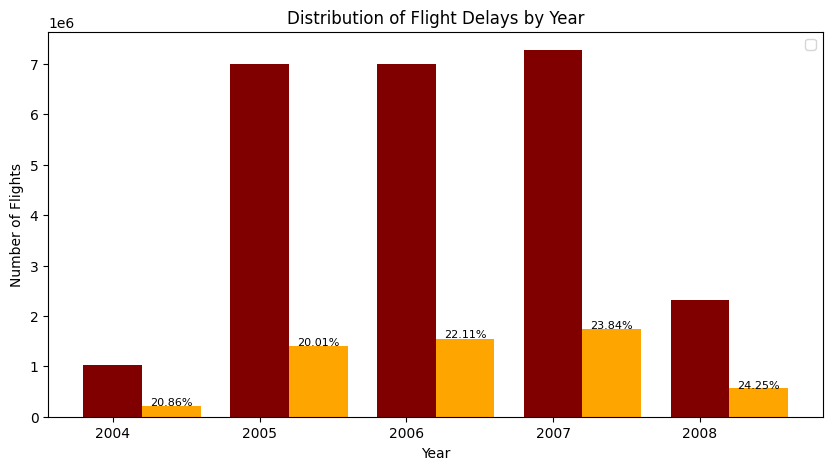

In [ ]:
# convert the rows into lists
year_list = [row.Year for row in yearly_counts_df.select("Year").collect()]
total_flights_list = [row.TotalFlights for row in yearly_counts_df.select("TotalFlights").collect()]
delayed_flights_list = [row.DelayedFlights for row in yearly_counts_df.select("DelayedFlights").collect()]
_2year_list = [x + 0.4 for x in year_list]

# get the percentages of the delayed flights over total flights
percentage = []
for i in range(len(total_flights_list)):
    pct = (delayed_flights_list[i] / total_flights_list[i]) * 100
    percentage.append(round(pct,2))

# plot
plt.figure(figsize=(10, 5))
plt.bar(year_list, total_flights_list, color ='maroon', width = 0.4)
graph = plt.bar(_2year_list, delayed_flights_list, color ='orange', width = 0.4)
plt.xlabel("Year")
plt.ylabel("Number of Flights")
plt.title("Distribution of Flight Delays by Year")
plt.legend()
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(percentage[i])+'%',
             ha='center',
             fontsize=8)
    i+=1

i = 0
plt.show()

## First Focusing on the Cancelled Flights

In [ ]:
cancelled_flights_df.show() # view a sample

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+
|year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|OnTime|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+
|2006|    5|        14|        7|      0|      1600|      0|      1939|  

### Drop the columns which do not provide us useful information for flight cancellations

In [ ]:
# List of columns to drop
columns_to_drop = ["DepTime", "ArrTime", "ActualElapsedTime", "AirTime", "ArrDelay", "DepDelay", \
                   "TaxiIn", "TaxiOut", "Diverted", "CarrierDelay","WeatherDelay","NASDelay", \
                   "SecurityDelay", "LateAircraftDelay","OnTime",]

# Select all columns except the ones to drop
cancelled_flights_df = cancelled_flights_df.select([column for column in cancelled_flights_df.columns if column not in columns_to_drop])
cancelled_flights_df = cancelled_flights_df.drop(*columns_to_drop)
cancelled_flights_df.show()

+----+-----+----------+---------+----------+----------+-------------+---------+-------+--------------+------+----+--------+---------+----------------+
|year|Month|DayofMonth|DayOfWeek|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|Origin|Dest|Distance|Cancelled|CancellationCode|
+----+-----+----------+---------+----------+----------+-------------+---------+-------+--------------+------+----+--------+---------+----------------+
|2006|    5|        14|        7|      1600|      1939|           CO|     1560|      0|           159|   IAH| MIA|     964|        1|               A|
|2006|    5|        29|        1|      1145|      1314|           CO|      655|      0|           209|   IAH| SNA|    1347|        1|               B|
|2006|    5|         5|        5|       550|       655|           CO|      214|      0|            65|   DFW| IAH|     224|        1|               A|
|2006|    5|        12|        5|      1725|      1925|           CO|     1430|      0|       

In [ ]:
# get the unique counts and values for each column in a specified dataframe
def get_unique_counts(col_name, main_df):
  new_df = main_df.groupBy(col_name).count()
  unique_values = new_df.select(col_name).rdd.flatMap(lambda x: x).collect()
  unique_counts = new_df.select("count").rdd.flatMap(lambda x: x).collect()
  return new_df, unique_values, unique_counts


### Now focusing on one column/variables at a time, to analyze the pattern for flight cancellations

#### Unique Carriers

In [ ]:
carrier_counts, unique_carriers, counts = get_unique_counts("UniqueCarrier", cancelled_flights_df)
print(len(unique_carriers), len(counts)) 
carrier_counts.show(n=10)

23 23
+-------------+-----+
|UniqueCarrier|count|
+-------------+-----+
|           UA|34408|
|           AA|51898|
|           NW|22421|
|           EV|33249|
|           B6| 6183|
|           DL|36928|
|           OO|45645|
|           F9| 1573|
|           YV|25981|
|           TZ| 1021|
+-------------+-----+
only showing top 10 rows



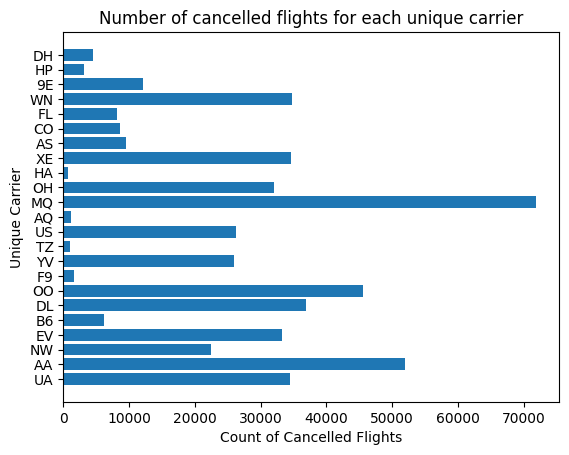

In [ ]:
# Create a horizontal bar chart
plt.barh(unique_carriers, counts)
plt.xlabel("Count of Cancelled Flights")
plt.ylabel("Unique Carrier")
plt.title("Number of cancelled flights for each unique carrier")
plt.show()

#### TailNum

In [ ]:
tailNum_df, unique_tailNum, unique_tailcounts = get_unique_counts("TailNum", cancelled_flights_df)
len(unique_tailNum), len(unique_tailcounts)

(3003, 3003)

#### FlightNum

In [ ]:
flightNum_df, unique_flightNum, unique_counts = get_unique_counts("FlightNum", cancelled_flights_df)
len(unique_flightNum), len(unique_counts)

(7788, 7788)

#### Origin

In [ ]:
origin_df, unique_origin, unique_origin_counts = get_unique_counts("Origin", cancelled_flights_df)
len(unique_origin), len(unique_origin_counts)

(314, 314)

In [ ]:
sorted_origin_df = origin_df.sort(desc("count"))
des_origin_df = origin_df.sort(asc("count"))

# Get the top 20 and bottom 20 values from the sorted DataFrame - 
top_20_values = sorted_origin_df.limit(20)
bottom_20_values = des_origin_df.limit(20)

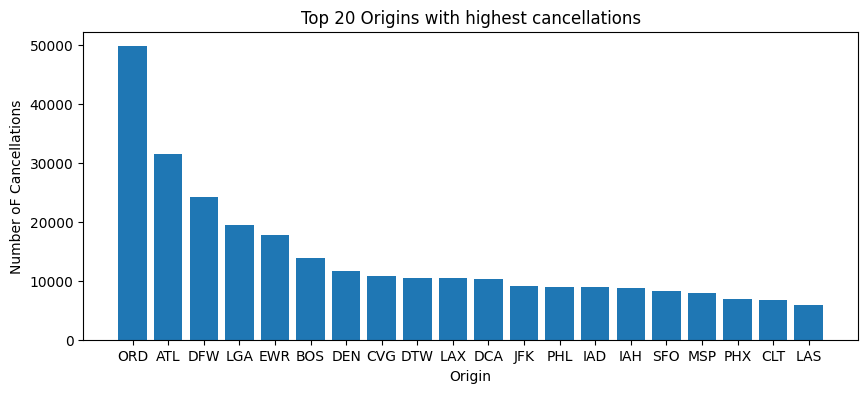

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(top_20_values.select("Origin").rdd.flatMap(lambda x: x).collect(),  top_20_values.select("count").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Origin")
plt.ylabel("Number oF Cancellations")
plt.title("Top 20 Origins with highest cancellations")
plt.show()

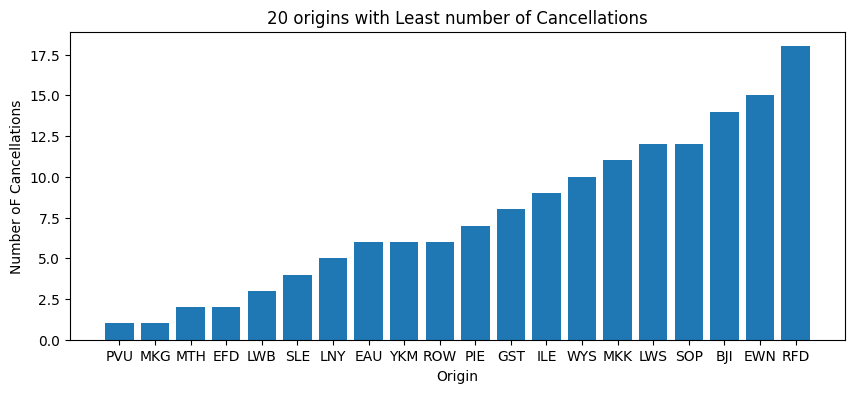

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(bottom_20_values.select("Origin").rdd.flatMap(lambda x: x).collect(),  bottom_20_values.select("count").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Origin")
plt.ylabel("Number oF Cancellations")
plt.title("20 origins with Least number of Cancellations")
plt.show()

Destination

In [ ]:
dest_df, unique_dest, unique_dest_counts = get_unique_counts("Dest", cancelled_flights_df)
len(unique_dest), len(unique_dest_counts)

(313, 313)

In [ ]:
sorted_dest_df = dest_df.sort(desc("count"))
des_dest_df = dest_df.sort(asc("count"))

# Get the top 20 values from the sorted DataFrame
top_20_values = sorted_dest_df.limit(20)
bottom_20_values = des_dest_df.limit(20)

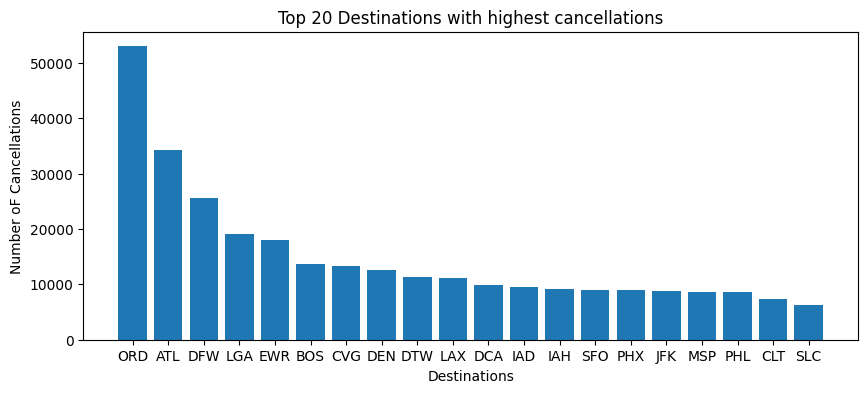

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(top_20_values.select("Dest").rdd.flatMap(lambda x: x).collect(),  top_20_values.select("count").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Destinations")
plt.ylabel("Number oF Cancellations")
plt.title("Top 20 Destinations with highest cancellations")
plt.show()

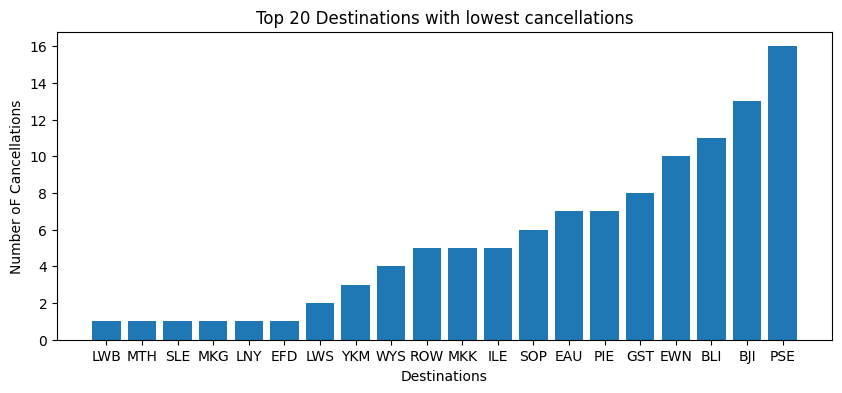

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(bottom_20_values.select("Dest").rdd.flatMap(lambda x: x).collect(),  bottom_20_values.select("count").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Destinations")
plt.ylabel("Number oF Cancellations")
plt.title("Top 20 Destinations with lowest cancellations")
plt.show()

##### Analyze the correlation between Origin and Cancellation

Correlation between Origin and Dest: 0.03165167437208367


<Axes: >

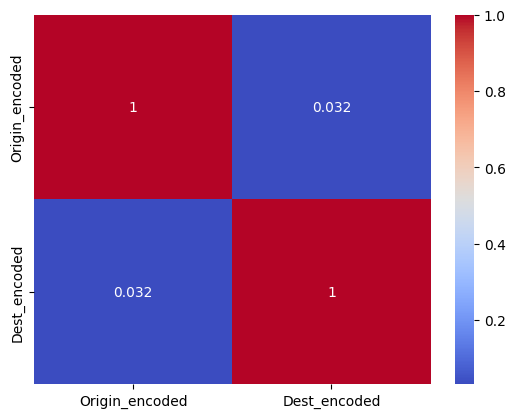

In [ ]:
cancelled_flights_df_pd = cancelled_flights_df.toPandas()

# LabelEncoder object 
label_encoder = LabelEncoder()

# Encode the "Origin" and "Dest" columns into numeric values for correlation calculation
cancelled_flights_df_pd["Origin_encoded"] = label_encoder.fit_transform(cancelled_flights_df_pd["Origin"])
cancelled_flights_df_pd["Dest_encoded"] = label_encoder.fit_transform(cancelled_flights_df_pd["Dest"])

# Calculate the correlation between "Origin_encoded" and "Dest_encoded"
correlation = cancelled_flights_df_pd["Origin_encoded"].corr(cancelled_flights_df_pd["Dest_encoded"])

print("Correlation between Origin and Dest:", correlation)

# Heatmap
sns.heatmap(cancelled_flights_df_pd[["Origin_encoded", "Dest_encoded"]].corr(), annot=True, cmap="coolwarm")


CSRElapsedTime

In [ ]:
crse_df, unique_crse, unique_crse_counts = get_unique_counts("CRSElapsedTime", cancelled_flights_df)
len(unique_crse), len(unique_crse_counts)

(494, 494)

In [ ]:
crse_df.show(n=10)

+--------------+-----+
|CRSElapsedTime|count|
+--------------+-----+
|           148| 1550|
|           471|    2|
|           463|    4|
|           496|    1|
|           243|  194|
|           392|   24|
|            31|   96|
|           137| 1783|
|            85|10122|
|           251|  140|
+--------------+-----+
only showing top 10 rows



In [ ]:
# Calculate the minimum, maximum, average values of the Distance column
min_value = cancelled_flights_df.agg(min("CRSElapsedTime")).collect()[0][0]
max_value = cancelled_flights_df.agg(max("CRSElapsedTime")).collect()[0][0]
mean_value = cancelled_flights_df.agg(avg("CRSElapsedTime")).collect()[0][0]

print("Minimum Value: ", min_value)
print("Maximum Value: ", max_value)
print("Mean Value: ", mean_value)

Minimum Value:  -1240
Maximum Value:  1435
Mean Value:  110.65226689731574


In [ ]:
bin_size = 50
# Add a new column to the DataFrame with the bin value and group by the crse_bin bin and then finally calculate the count of occurrences in each bin
df = cancelled_flights_df.withColumn("crse_bin", floor(col("CRSElapsedTime") / bin_size) * bin_size)
bin_counts = df.groupBy("crse_bin").count()
bin_counts = bin_counts.sort(desc("crse_bin"))
bin_counts.show()

+--------+------+
|crse_bin| count|
+--------+------+
|    1400|     3|
|     650|     4|
|     600|     1|
|     550|    16|
|     500|    61|
|     450|   156|
|     400|   222|
|     350|  2366|
|     300|  4542|
|     250|  7768|
|     200| 18893|
|     150| 61354|
|     100|149497|
|      50|242102|
|       0| 19409|
|     -50|     2|
|   -1250|     1|
+--------+------+



In [ ]:
num_bins = bin_counts.count()
print("Number of bins: ", num_bins)
crs_inter = bin_counts.select("crse_bin").rdd.flatMap(lambda x: x).collect()
crs_inter_counts = bin_counts.select("count").rdd.flatMap(lambda x: x).collect()
len(crs_inter), len(crs_inter_counts)

Number of bins:  17


(17, 17)

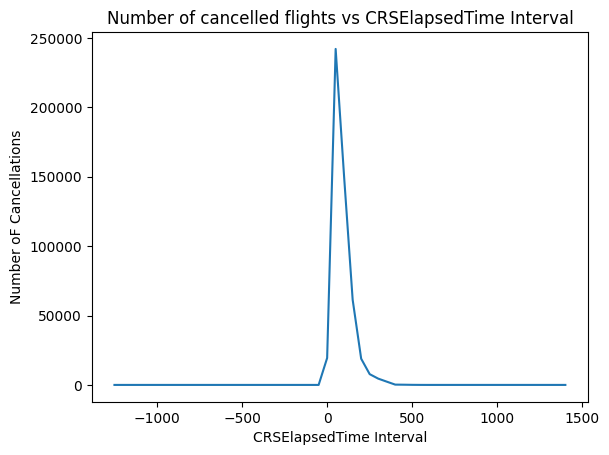

In [ ]:
plt.plot(crs_inter, crs_inter_counts)
plt.xlabel("CRSElapsedTime Interval")
plt.ylabel("Number oF Cancellations")
plt.title("Number of cancelled flights vs CRSElapsedTime Interval")
plt.show()

#### Cancellation Code

In [ ]:
cancelCode_df, unique_cancelCode, unique_cancelCode_counts = get_unique_counts("CancellationCode", cancelled_flights_df)
print(len(unique_cancelCode), len(unique_cancelCode_counts))
cancelCode_df.show()

4 4
+----------------+------+
|CancellationCode| count|
+----------------+------+
|               B|188042|
|               D|   313|
|               C| 99558|
|               A|218484|
+----------------+------+



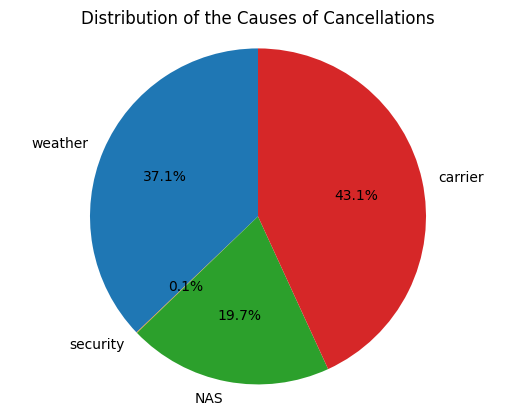

In [ ]:
labels = ["weather", "security", "NAS", "carrier"]
plt.pie(unique_cancelCode_counts, labels=labels, autopct='%1.1f%%', startangle=90,)
plt.axis('equal') 
plt.title("Distribution of the Causes of Cancellations")
plt.show()

#### Distance

In [ ]:
dist_df, unique_dist, unique_dist_counts = get_unique_counts("Distance", cancelled_flights_df)
len(unique_dist), len(unique_dist_counts)

(1412, 1412)

In [ ]:
# Calculate the minimum, maximum, and mean values of the Distance column
min_value = cancelled_flights_df.agg(min("Distance")).collect()[0][0]
max_value = cancelled_flights_df.agg(max("Distance")).collect()[0][0]
mean_value = cancelled_flights_df.agg(avg("Distance")).collect()[0][0]
print("Minimum Value: ", min_value)
print("Maximum Value: ", max_value)
print("Mean Value: ", mean_value)

Minimum Value:  11
Maximum Value:  4962
Mean Value:  565.4784822974859


In [ ]:
bin_size = 100
df = cancelled_flights_df.withColumn("distance_bin", floor(col("Distance") / bin_size) * bin_size)
bin_counts = df.groupBy("distance_bin").count()
bin_counts.show(n=20)

+------------+-----+
|distance_bin|count|
+------------+-----+
|           0|12292|
|        2900|   74|
|        2400| 2505|
|        3200|    5|
|        1200| 4767|
|        2300| 1005|
|        2700|  384|
|         600|40938|
|         700|32289|
|        4900|   12|
|        1800| 2054|
|        3700|   25|
|        1100| 8566|
|        3300|   14|
|         900|18834|
|        1700| 4380|
|         500|50031|
|        1000|16312|
|        4500|   13|
|        1400| 5339|
+------------+-----+
only showing top 20 rows



In [ ]:
num_bins = bin_counts.count()
print("Number of bins: ", num_bins)
dist_inter = bin_counts.select("distance_bin").rdd.flatMap(lambda x: x).collect()
dist_inter_counts = bin_counts.select("count").rdd.flatMap(lambda x: x).collect()
len(dist_inter), len(dist_inter_counts)

Number of bins:  42


(42, 42)

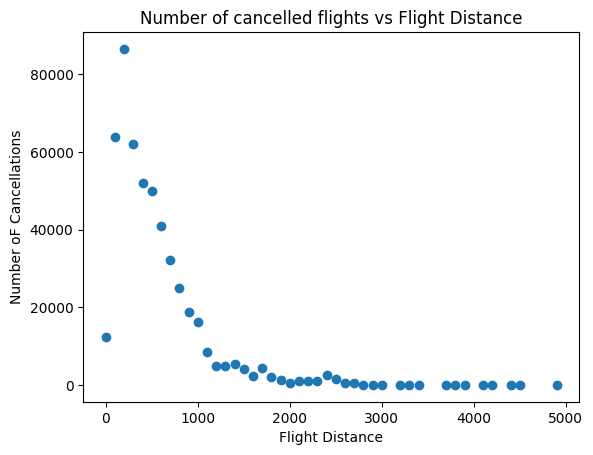

In [ ]:
plt.scatter(dist_inter, dist_inter_counts)
plt.xlabel("Flight Distance")
plt.ylabel("Number oF Cancellations")
plt.title("Number of cancelled flights vs Flight Distance")
plt.show()

#### Weather vs Time

In [ ]:
# Dictionary to map integer values to months
month_mapping = {
    1: "Jan",
    2: "Feb",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "Aug",
    9: "Sept",
    10: "Oct",
    11: "Nov",
    12: "Dec"
}

# Dictionary to map integer values to days of the week
day_mapping = {
    1: "Mon",
    2: "Tues",
    3: "Wed",
    4: "Thur",
    5: "Fri",
    6: "Sat",
    7: "Sun"
}

# only select the cancellations due to weather
weather_cancellations_df = cancelled_flights_df.filter(flights_df["CancellationCode"] == "B")
# Group by Month and calculate the count of weather cancellations
weather_cancellations_by_month = weather_cancellations_df.groupBy("Month").agg(count("*").alias("WeatherCancellationCountByMonth"))
# Group by DayOfYear and calculate the count of weather cancellations
weather_cancellations_by_day = weather_cancellations_df.groupBy("DayOfWeek").agg(count("*").alias("WeatherCancellationCountByDay"))
weather_cancellations_df.show(n=5)

+----+-----+----------+---------+----------+----------+-------------+---------+-------+--------------+------+----+--------+---------+----------------+
|year|Month|DayofMonth|DayOfWeek|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|Origin|Dest|Distance|Cancelled|CancellationCode|
+----+-----+----------+---------+----------+----------+-------------+---------+-------+--------------+------+----+--------+---------+----------------+
|2006|    5|        29|        1|      1145|      1314|           CO|      655|      0|           209|   IAH| SNA|    1347|        1|               B|
|2006|    5|        29|        1|       915|      1025|           CO|      623|      0|            70|   IAH| MSY|     305|        1|               B|
|2006|    5|        29|        1|      1110|      1210|           CO|     1529|      0|            60|   AUS| IAH|     140|        1|               B|
|2006|    5|         6|        6|      1855|      2053|           DL|      554| N972DL|       

In [ ]:
weather_cancellations_by_month.show()

+-----+-------------------------------+
|Month|WeatherCancellationCountByMonth|
+-----+-------------------------------+
|    1|                          42641|
|    6|                           8379|
|    3|                          20740|
|    5|                           4021|
|    8|                           8499|
|    7|                           8970|
|    2|                          37832|
|    9|                           7605|
|    4|                           8368|
|   10|                           8834|
|   12|                          26210|
|   11|                           5943|
+-----+-------------------------------+



In [ ]:
weather_cancellations_by_day.show()

+---------+-----------------------------+
|DayOfWeek|WeatherCancellationCountByDay|
+---------+-----------------------------+
|        1|                        24153|
|        6|                        23858|
|        3|                        27394|
|        5|                        31201|
|        4|                        27703|
|        7|                        26663|
|        2|                        27070|
+---------+-----------------------------+



In [ ]:
day_integers = [x for x in range(1, 8)]
# Map integer array to days of the week using the dictionary mapping
days_of_week = [day_mapping.get(day_int, "Unknown") for day_int in day_integers]

month_integers = [x for x in range(1, 13)]
# Map integer array to months using the dictionary mapping
months = [month_mapping.get(month_int, "Unknown") for month_int in month_integers]
print(days_of_week)
print(months)

['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']


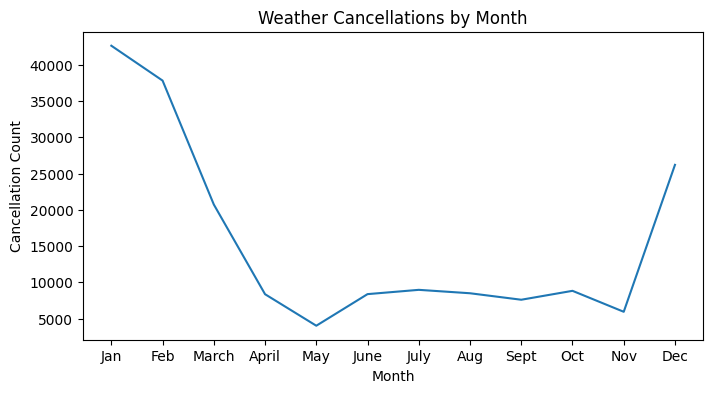

In [ ]:
# Line chart of weather cancellations by month
plt.figure(figsize=(8,4))
g = sns.lineplot(x="Month", y="WeatherCancellationCountByMonth", data=weather_cancellations_by_month.toPandas())
g.set_xticks(range(1,13))
g.set_xticklabels(months)
plt.title("Weather Cancellations by Month")
plt.xlabel("Month")
plt.ylabel("Cancellation Count")
plt.show()

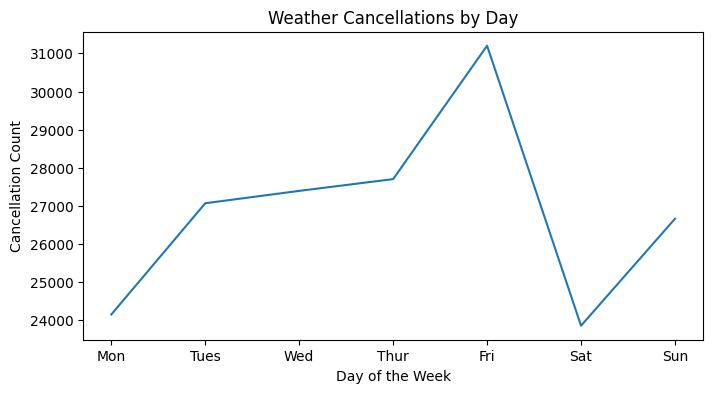

In [ ]:
# Line chart of weather cancellations by day
plt.figure(figsize=(8,4))
g=sns.lineplot(x="DayOfWeek", y="WeatherCancellationCountByDay", data=weather_cancellations_by_day.toPandas())
g.set_xticks(range(1,8))
g.set_xticklabels(days_of_week)
plt.title("Weather Cancellations by Day")
plt.xlabel("Day of the Week")
plt.ylabel("Cancellation Count")
plt.show()


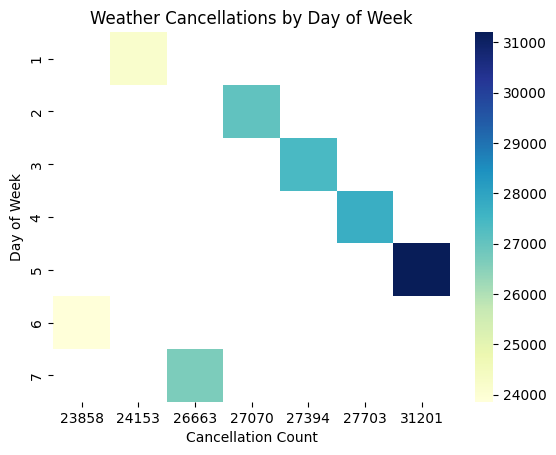

In [ ]:
# Heatmap of weather cancellations by day of year
weather_cancellations_by_day_pd = weather_cancellations_by_day.toPandas()
weather_cancellations_heatmap = weather_cancellations_by_day_pd.pivot(index="DayOfWeek", columns="WeatherCancellationCountByDay", values="WeatherCancellationCountByDay")
sns.heatmap(weather_cancellations_heatmap, cmap="YlGnBu")
plt.title("Weather Cancellations by Day of Week")
plt.xlabel("Cancellation Count")
plt.ylabel("Day of Week")
plt.show()

#### Combined Variables  Counts

In [ ]:
# Meaning of variables ==> counts -  unique carrier, unique_counts - flight Num, unique_tailcounts - tailNum
combined_counts = [counts, unique_counts, unique_tailcounts, unique_origin_counts, unique_dest_counts, unique_cancelCode_counts, unique_dist_counts]
data_names = ['UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'CancelCode', 'Distance']

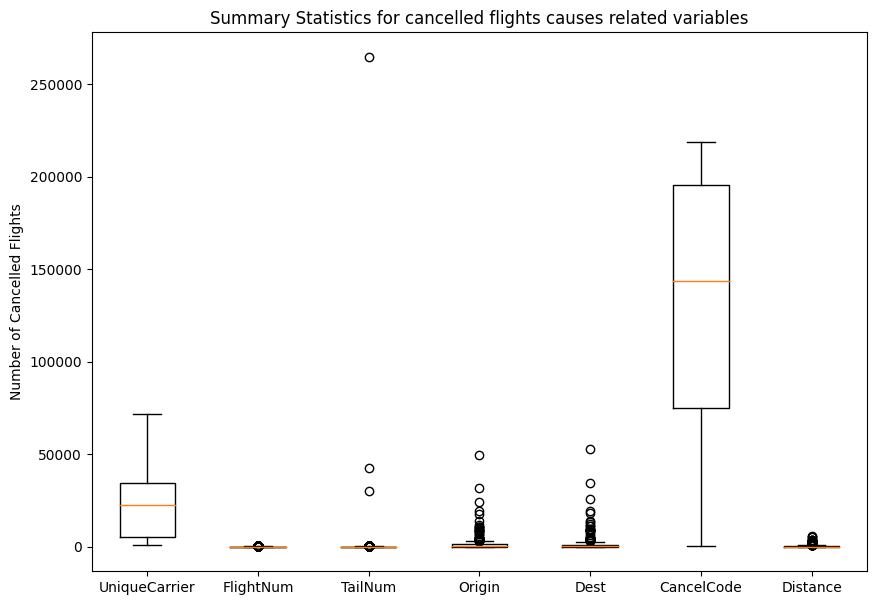

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.boxplot(combined_counts)
ax.set_xticklabels(data_names)
plt.ylabel("Number of Cancelled Flights")
plt.title("Summary Statistics for cancelled flights causes related variables")
plt.show()

### Effect of plane-related data on the cancellations

In [ ]:
# Load the plane data csv file into a Pandas DataFrame from disk 
plane_data_df = pd.read_csv("plane_data.csv")

# Data Cleaning - drop rows with missing values
plane_data_df.dropna(inplace=True)
plane_data_df.drop(['issue_date'], axis=1, inplace=True)
plane_data_df['year'] = pd.to_numeric(plane_data_df['year'], errors='coerce') # replace non-numeric values with NaN

In [ ]:
# select the cancellations due to the carrier-related issues
carrier_cancellations_df = cancelled_flights_df.filter(flights_df["CancellationCode"] == "A")

In [ ]:
# Convert pandas df to spark df
plane_data_spark_df = spark.createDataFrame(plane_data_df)
plane_data_spark_df = plane_data_spark_df.withColumnRenamed("year", "Plane_Year")

# Join the two dataframes on 'tailNum'
joined_df = carrier_cancellations_df.join(plane_data_spark_df, "tailNum")

# Convert 'year' column to integer type
joined_df = joined_df.withColumn("Plane_Year", col("Plane_Year").cast(IntegerType()))
joined_df.show(n=10)

+-------+----+-----+----------+---------+----------+----------+-------------+---------+--------------+------+----+--------+---------+----------------+-----------+--------------------+-------+------+--------------------+-----------+----------+
|TailNum|year|Month|DayofMonth|DayOfWeek|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|CRSElapsedTime|Origin|Dest|Distance|Cancelled|CancellationCode|       type|        manufacturer|  model|status|       aircraft_type|engine_type|Plane_Year|
+-------+----+-----+----------+---------+----------+----------+-------------+---------+--------------+------+----+--------+---------+----------------+-----------+--------------------+-------+------+--------------------+-----------+----------+
| N902DE|2006|    5|        14|        7|      2100|      2322|           DL|      643|           142|   LGA| ATL|     761|        1|               A|Corporation|MCDONNELL DOUGLAS...|  MD-88| Valid|Fixed Wing Multi-...|  Turbo-Jet|      1992|
| N902DE|2006|    5|        

In [ ]:
plane_year_df, unique_plane_year, unique_plane_year_counts = get_unique_counts("Plane_Year", joined_df)
print(len(unique_plane_year), len(unique_plane_year_counts))
plane_year_df.show()

41 41
+----------+-----+
|Plane_Year|count|
+----------+-----+
|      1990| 2301|
|      1975|  375|
|      1977|  234|
|      2003| 5834|
|      2007|  160|
|      2006|  727|
|      1978|  422|
|      1988| 1708|
|      1997| 3055|
|      1994| 1740|
|      1968| 1630|
|      1973|  112|
|      1979|  577|
|      1971|   84|
|      1966|   43|
|      2004| 3004|
|      1991| 2366|
|      1967| 1055|
|      1969|  851|
|      1957|   20|
+----------+-----+
only showing top 20 rows



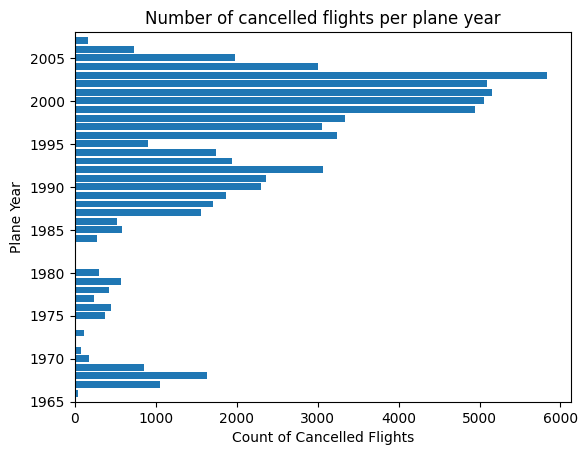

In [ ]:
# Horizontal bar chart
fig, ax = plt.subplots()
ax.barh(unique_plane_year, unique_plane_year_counts, height=0.8)
ax.set_ylim([1965,2008])
plt.xlabel("Count of Cancelled Flights")
plt.ylabel("Plane Year")
plt.title("Number of cancelled flights per plane year")
plt.show()

### Effect of the plane model on the rate of cancellations

In [ ]:
plane_model_df, unique_plane_model, unique_plane_model_counts = get_unique_counts("model", joined_df)
print(len(unique_plane_model), len(unique_plane_model_counts))
plane_model_df.sort(desc("count")).show(n=10)

80 80
+-----------+-----+
|      model|count|
+-----------+-----+
|CL-600-2B19|21416|
|      MD-88| 8287|
|CL-600-2C10| 6038|
|    717-200| 3029|
| CL600-2D24| 2535|
|    DC-9-51| 2196|
|    DC-9-31| 2180|
|    757-232| 2069|
|  DHC-8-202| 1951|
|   A319-114| 1382|
+-----------+-----+
only showing top 10 rows



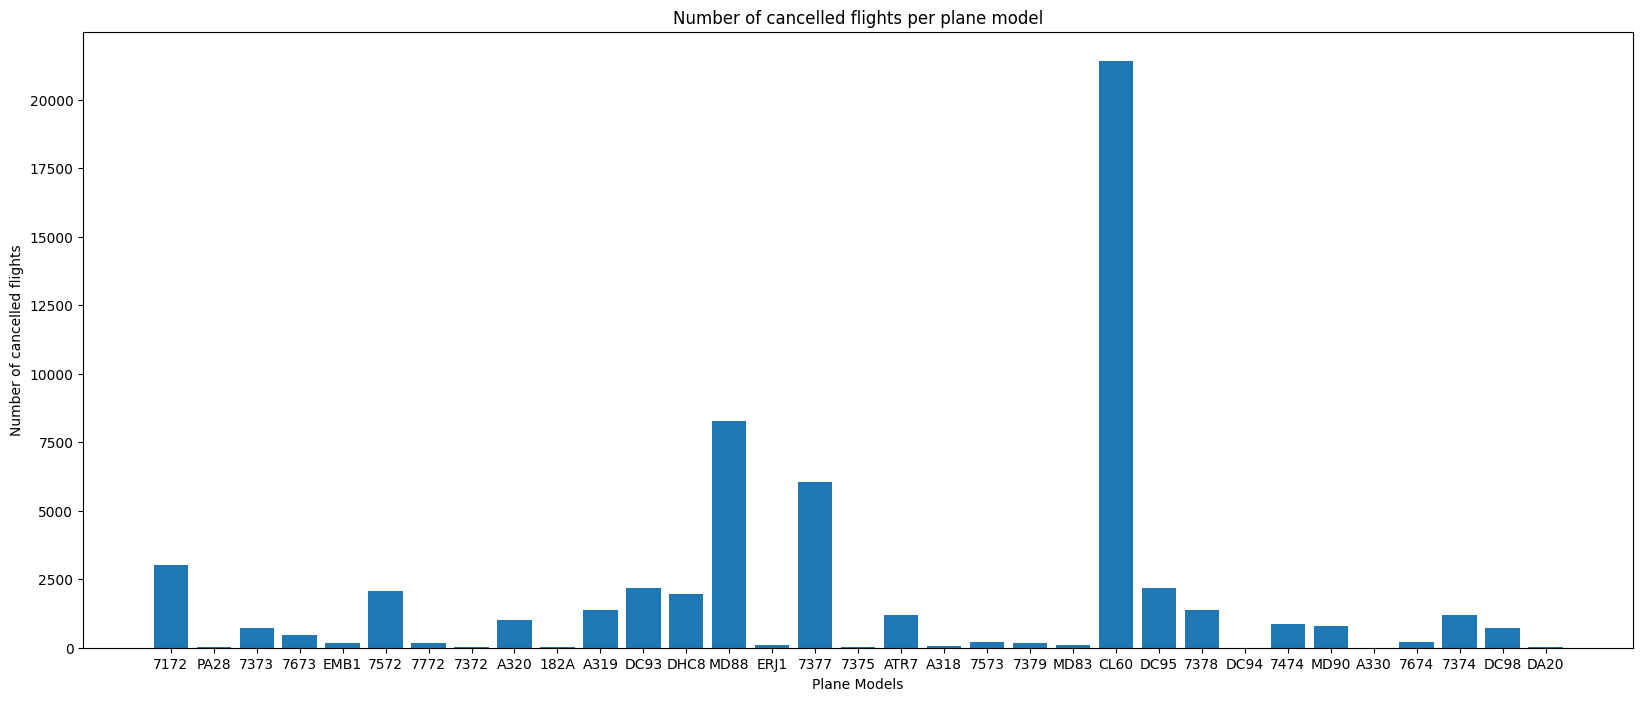

In [ ]:
# replace the the long model names with shorter characters for each display
def generate_encoding(word):
    # remove any spaces or special characters from the word
    word = word.replace(' ', '').replace('-', '').replace('(', '').replace(')', '').replace('_', '')
    # Take the first 4 characters from the word
    encoding = word[:4]
    return encoding

# Generate the encodings for each word
model_encodings = [generate_encoding(word) for word in unique_plane_model]

#Plot
plt.figure(figsize=(20, 8))
plt.bar(model_encodings, unique_plane_model_counts)
plt.xlabel("Plane Models")
plt.ylabel("Number of cancelled flights")
plt.title("Number of cancelled flights per plane model")
plt.show()

### What are the causes of cancellation for the models with the highest cancellations?

In [ ]:
CL_600_2B19_model = joined_df.filter(joined_df["model"] == "CL-600-2B19")
MD_88_model = joined_df.filter(joined_df["model"] == "MD-88")
CL_600_2C10_model = joined_df.filter(joined_df["model"] == "CL-600-2C10")

In [ ]:
CL_600_2B19_model_cancellation_causes = CL_600_2B19_model.groupBy("CancellationCode").count()
CL_600_2B19_model_cancellation_causes.show()

+----------------+-----+
|CancellationCode|count|
+----------------+-----+
|               A|21416|
+----------------+-----+



In [ ]:
MD_88_model_cancellation_causes = MD_88_model.groupBy("CancellationCode").count()
MD_88_model_cancellation_causes.show()

+----------------+-----+
|CancellationCode|count|
+----------------+-----+
|               A| 8287|
+----------------+-----+



In [ ]:
CL_600_2C10_model_cancellation_causes = CL_600_2C10_model.groupBy("CancellationCode").count()
CL_600_2C10_model_cancellation_causes.show()

+----------------+-----+
|CancellationCode|count|
+----------------+-----+
|               A| 6038|
+----------------+-----+



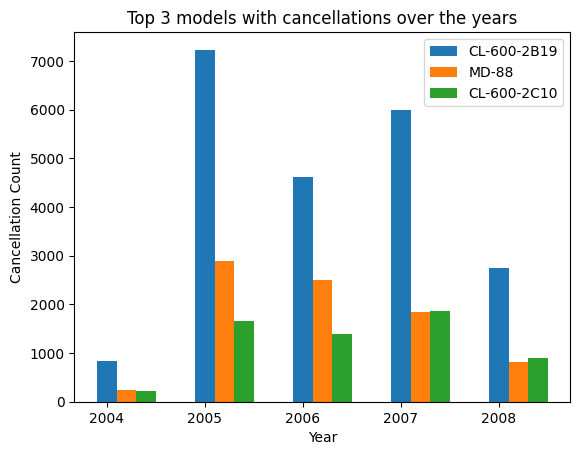

In [ ]:
CL_600_2B19_model_cancellation_yearly = CL_600_2B19_model.groupBy("year").count()
MD_88_model_cancellation_yearly = MD_88_model.groupBy("year").count()
CL_600_2C10_model_cancellation_yearly = CL_600_2C10_model.groupBy("year").count()

# get the unique counts for each dataframe
def get_model_counts(new_df):
  unique_counts = new_df.select("count").rdd.flatMap(lambda x: x).collect()
  return unique_counts

model_years = [2007, 2006, 2004, 2005, 2008]

# Data for Model 1
model1_cancellation_data = {'CancellationCode': ['A', 'A', 'A', 'A', 'A'],
                            'count':get_model_counts(CL_600_2B19_model_cancellation_yearly),
                            'year': model_years}

# Data for Model 2
model2_cancellation_data = {'CancellationCode': ['A', 'A', 'A', 'A', 'A'],
                            'count':get_model_counts(MD_88_model_cancellation_yearly),
                            'year': model_years}


# Data for Model 3
model3_cancellation_data = {'CancellationCode': ['A', 'A', 'A', 'A', 'A'],
                            'count':get_model_counts(CL_600_2C10_model_cancellation_yearly),
                            'year': model_years}
# Create a figure and axis
fig, ax = plt.subplots()

# Get unique years
years = sorted(list(set(model1_cancellation_data['year'] + model2_cancellation_data['year'] + model3_cancellation_data['year'])))

# Initialize count for each model for each year
model1_counts = [0] * len(years)
model2_counts = [0] * len(years)
model3_counts = [0] * len(years)

# Calculate counts for Model 1, Model 2 and Model 3 for each year
for i, year in enumerate(years):
    if year in model1_cancellation_data['year']:
        model1_counts[i] = model1_cancellation_data['count'][model1_cancellation_data['year'].index(year)]
    if year in model2_cancellation_data['year']:
        model2_counts[i] = model2_cancellation_data['count'][model2_cancellation_data['year'].index(year)]
    if year in model3_cancellation_data['year']:
        model3_counts[i] = model3_cancellation_data['count'][model3_cancellation_data['year'].index(year)]

# Plot bar chart
ax.bar(years, model1_counts, label='CL-600-2B19',  width = 0.2)
ax.bar([x + 0.2 for x in years], model2_counts, label='MD-88',  width = 0.2)
ax.bar([x + 0.4 for x in years], model3_counts, label='CL-600-2C10',  width = 0.2)

ax.set_xlabel('Year')
ax.set_ylabel('Cancellation Count')
ax.set_title('Top 3 models with cancellations over the years')
ax.legend()
plt.show()


### Get correlation matrix to see how variables are correlated for further analysis

In [ ]:
joined_df_2 = joined_df
string_cols = ['TailNum', 'UniqueCarrier', 'Origin', 'Dest', 'CancellationCode', 'type',  'manufacturer', 'model', 'status', 'aircraft_type', 'engine_type' ]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(joined_df_2) for col in string_cols]
for indexer in indexers:
    joined_df_2 = indexer.transform(joined_df_2)

# List of columns to be removed
columns_to_remove = ["Cancelled", "CancellationCode_index", "status_index"]
# Remove columns from the DataFrame
joined_df_2 = joined_df_2.select([col for col in joined_df_2.columns if col not in columns_to_remove])


<ipython-input-67-8138261f6df9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat_2 = joined_df_2.toPandas().corr()


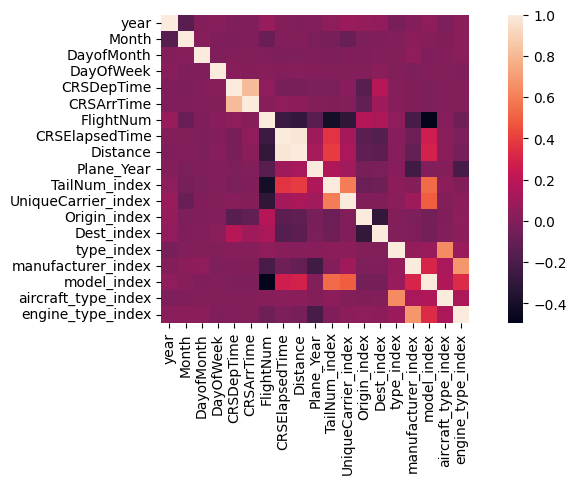

In [ ]:
# correlation matrix
corrmat_2 = joined_df_2.toPandas().corr()
f, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(corrmat_2, vmax=1.0, square=True);
plt.show()

### Generate heatmaps for the correlation between the model, manufacturer and the cancellation rate, since from the previous matrix there is some correlation

In [ ]:
cancelled_flights_pd = cancelled_flights_df.toPandas()
joined_df2 = cancelled_flights_df.join(plane_data_spark_df, "tailNum")
joined_df2 = joined_df2.toPandas()


Correlation between model_encoded and CC_encoded: 0.050958174180748675


<Axes: >

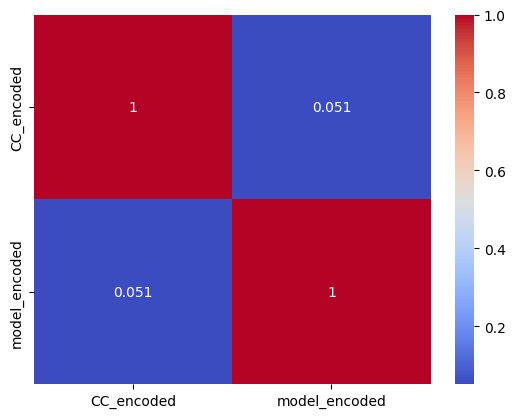

In [ ]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode the "CancellationCode" and "model" columns into numeric values
joined_df2["CC_encoded"] = label_encoder.fit_transform(joined_df2["CancellationCode"])
joined_df2["model_encoded"] = label_encoder.fit_transform(joined_df2["model"])

# Calculate the correlation between "CancellationCode" and "model_encoded"
correlation = joined_df2["CC_encoded"].corr(joined_df2["model_encoded"])
print("Correlation between model_encoded and CC_encoded:", correlation)

#heatmap
sns.heatmap(joined_df2[["CC_encoded", "model_encoded"]].corr(), annot=True, cmap="coolwarm")

Correlation between manufacturer_encoded and CC_encoded: 0.005723737982956233


<Axes: >

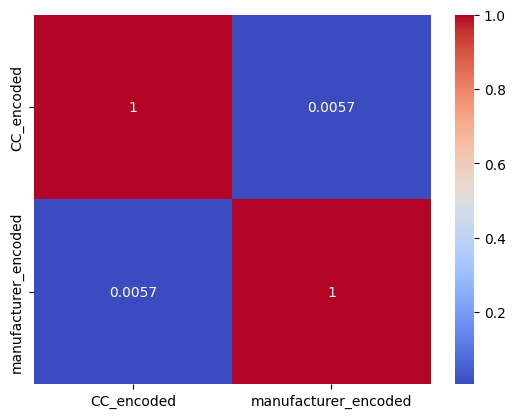

In [ ]:
# Encode the "CancellationCode" and "manufacturer" columns into numeric values
joined_df2["CC_encoded"] = label_encoder.fit_transform(joined_df2["CancellationCode"])
joined_df2["manufacturer_encoded"] = label_encoder.fit_transform(joined_df2["manufacturer"])

# Calculate the correlation between "CancellationCode" and "manufacturer_encoded"
correlation = joined_df2["CC_encoded"].corr(joined_df2["manufacturer_encoded"])

print("Correlation between manufacturer_encoded and CC_encoded:", correlation)
# Heatmap 
sns.heatmap(joined_df2[["CC_encoded", "manufacturer_encoded"]].corr(), annot=True, cmap="coolwarm")


### Causes of cancellations depending on the routes
-since previously we observed that the origin and destination have a high correlation - now consider the routes

In [ ]:
#cancelled_flights_df  
count_by_key = cancelled_flights_df.groupBy("Origin", "Dest").count()
sorted_count_by_key = count_by_key.sort(desc("count"))
sorted_count_by_key.show()

+------+----+-----+
|Origin|Dest|count|
+------+----+-----+
|   LGA| ORD| 2476|
|   DCA| LGA| 2436|
|   LGA| BOS| 2425|
|   ORD| LGA| 2424|
|   BOS| LGA| 2411|
|   LGA| DCA| 2388|
|   HOU| DAL| 1493|
|   DAL| HOU| 1426|
|   DCA| BOS| 1414|
|   DCA| ORD| 1409|
|   ORD| MSP| 1354|
|   LGA| ATL| 1348|
|   MSP| ORD| 1340|
|   ORD| DCA| 1337|
|   BOS| DCA| 1322|
|   EWR| ORD| 1299|
|   ORD| EWR| 1272|
|   ATL| LGA| 1264|
|   PHL| ORD| 1261|
|   ORD| CVG| 1252|
+------+----+-----+
only showing top 20 rows



In [ ]:
# get the total number of routes
sorted_count_by_key.count()

5263

In [ ]:
# map func
def map_func(row):
    # Concatenate "Origin" and "Dest" in alphabetical order as the key
    key = "_".join(sorted([row["Origin"], row["Dest"]]))
    value = row["count"]
    return (key, value)

# mapping each row in the DataFrame
mapped_routes = count_by_key.rdd.map(map_func)

# reduce func
def reduce_func(key_value_pair):
    key = key_value_pair[0]
    values = key_value_pair[1]
    # Check if the key has two key-value pairs (one for each direction)
    if len(values) == 2:
        # Check if both counts are non-zero
        if all(count > 0 for count in values):
            return True
    return False

# Group the key-value pairs by key and aggregate the values using a list
grouped_routes = mapped_routes.groupByKey()

# Apply the reduce function to each group of key-value pairs
filtered_routes = grouped_routes.filter(reduce_func)

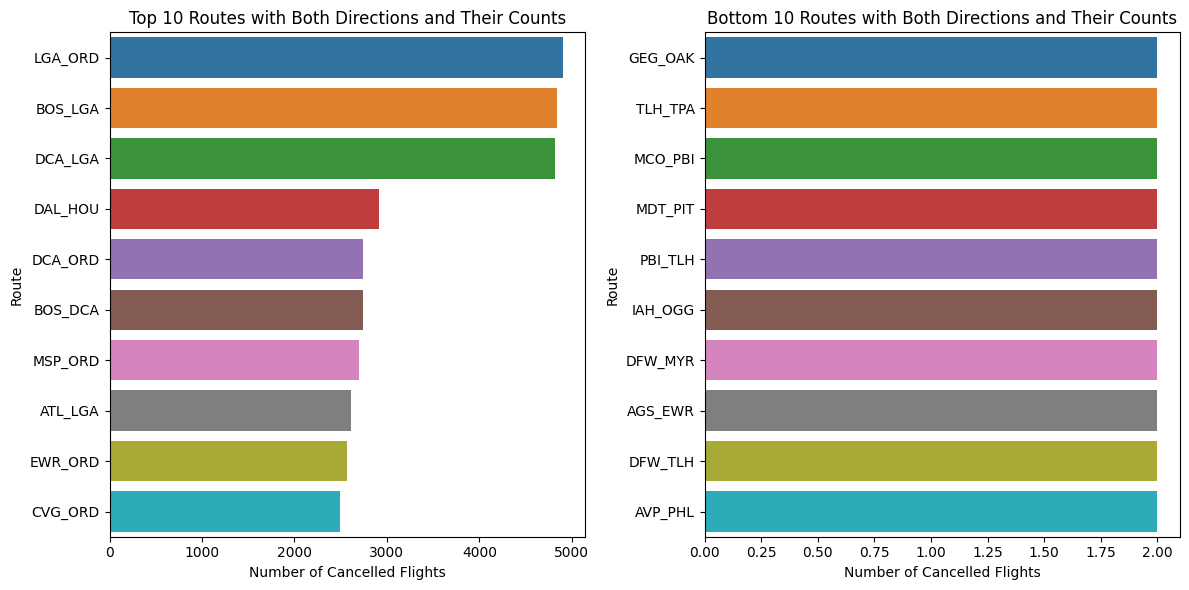

In [ ]:
# Convert the routes with both directions and counts to a list of tuples
routes_with_both_directions = filtered_routes.map(lambda x: (x[0], sum(x[1]))).collect()

# Sort the routes by counts in descending order
sorted_routes = sorted(routes_with_both_directions, key=lambda x: x[1], reverse=True)

# Extract the top 10 and bottom routes
top_10 = sorted_routes[:10]
bottom_10 = sorted_routes[-10:]

# Extract the routes and counts into separate lists for top 10 and bottom routes
top_10_routes = [route for route, count in top_10]
top_10_counts = [count for route, count in top_10]
bottom_routes = [route for route, count in bottom_10]
bottom_counts = [count for route, count in bottom_10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# horizontal bar plot for top 10 routes
sns.barplot(x=top_10_counts, y=top_10_routes, ax=ax1)
ax1.set_title("Top 10 Routes with Both Directions and Their Counts")
ax1.set_xlabel("Number of Cancelled Flights")
ax1.set_ylabel("Route")

# horizontal bar plot for bottom routes
sns.barplot(x=bottom_counts, y=bottom_routes, ax=ax2)
ax2.set_title("Bottom 10 Routes with Both Directions and Their Counts")
ax2.set_xlabel("Number of Cancelled Flights")
ax2.set_ylabel("Route")

plt.tight_layout()
plt.show()


## Focusing on Diverted Flights

In [ ]:
diverted_flights_df.show()

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+
|year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|OnTime|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+
|2006|    5|        29|        1|    705|       705|      0|       825|  

In [ ]:
delayed_diverted_count = diverted_flights_df.groupBy("OnTime").count()
delayed_diverted_count.show()

+------+-----+
|OnTime|count|
+------+-----+
|  true|54661|
+------+-----+



In [ ]:
cancelled_diverted_count = diverted_flights_df.groupBy("Cancelled").count()
cancelled_diverted_count.show()

+---------+-----+
|Cancelled|count|
+---------+-----+
|        0|54661|
+---------+-----+



## Focusing on Delayed Flights

In [ ]:
delayed_flights_df.show()

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+
|year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|OnTime|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+------+
|2006|    5|         6|        6|   1110|      1100|   1244|      1213|  

In [ ]:
# get the unique counts for each dataframe
def get_unique_counts(col_name, main_df):
  new_df = main_df.groupBy(col_name).count()
  unique_values = new_df.select(col_name).rdd.flatMap(lambda x: x).collect()
  unique_counts = new_df.select("count").rdd.flatMap(lambda x: x).collect()
  return new_df, unique_values, unique_counts


#### Unique Carriers

In [ ]:
carrier_counts, unique_carriers, counts = get_unique_counts("UniqueCarrier", delayed_flights_df)
print(len(unique_carriers), len(counts))
carrier_counts.show(n=10)

23 23
+-------------+------+
|UniqueCarrier| count|
+-------------+------+
|           UA|417014|
|           AA|558393|
|           NW|380225|
|           EV|283524|
|           B6|142608|
|           DL|405669|
|           OO|382420|
|           F9| 53929|
|           YV|158751|
|           TZ| 16552|
+-------------+------+
only showing top 10 rows



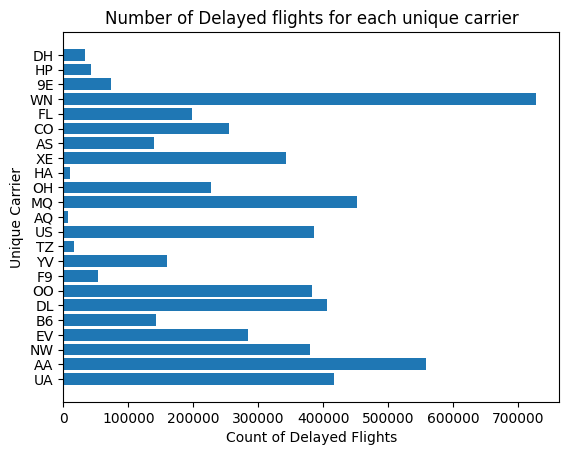

In [ ]:
# horizontal bar chart
plt.barh(unique_carriers, counts)
plt.xlabel("Count of Delayed Flights")
plt.ylabel("Unique Carrier")
plt.title("Number of Delayed flights for each unique carrier")
plt.show()

In [ ]:
tailNum_df, unique_tailNum, unique_tailcounts = get_unique_counts("TailNum", delayed_flights_df)
len(unique_tailNum), len(unique_tailcounts)

(6871, 6871)

#### FlightNum

In [ ]:
flightNum_df, unique_flightNum, unique_counts = get_unique_counts("FlightNum", delayed_flights_df)
len(unique_flightNum), len(unique_counts)

(7924, 7924)

#### Origin

In [ ]:
origin_df, unique_origin, unique_origin_counts = get_unique_counts("Origin", delayed_flights_df)
len(unique_origin), len(unique_origin_counts)

(318, 318)

In [ ]:
sorted_origin_df = origin_df.sort(desc("count"))
des_origin_df = origin_df.sort(asc("count"))

# Get the top and bottom 20 values from the sorted DataFrame
top_20_values = sorted_origin_df.limit(20)
bottom_20_values = des_origin_df.limit(20)

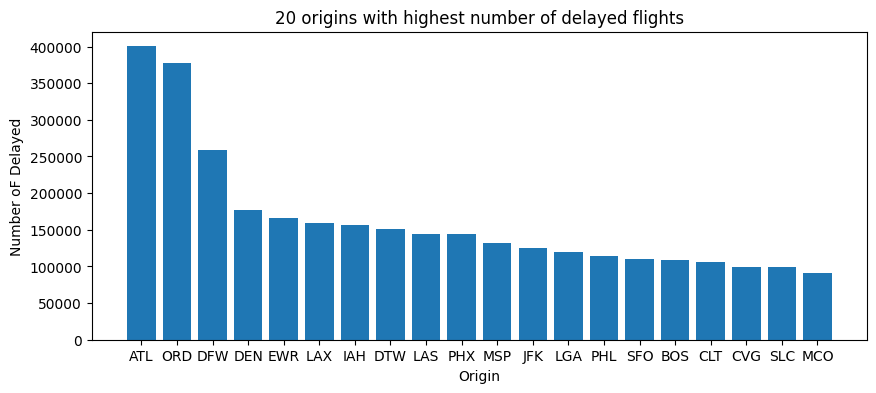

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(top_20_values.select("Origin").rdd.flatMap(lambda x: x).collect(),  top_20_values.select("count").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Origin")
plt.ylabel("Number oF Delayed")
plt.title("20 origins with highest number of delayed flights")
plt.show()

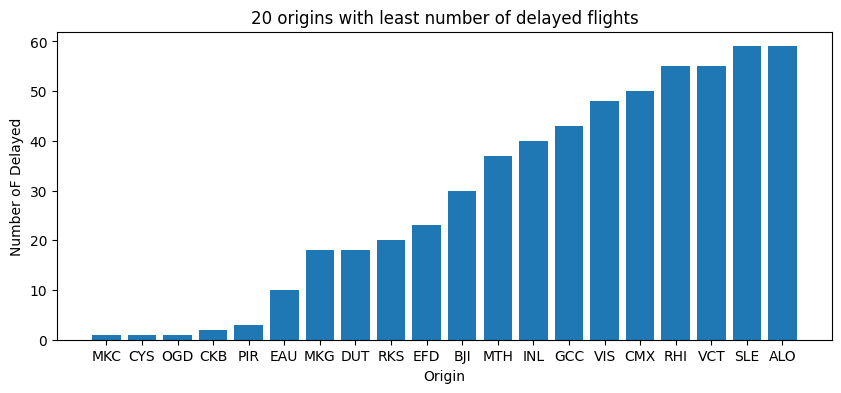

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(bottom_20_values.select("Origin").rdd.flatMap(lambda x: x).collect(),  bottom_20_values.select("count").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Origin")
plt.ylabel("Number oF Delayed")
plt.title("20 origins with least number of delayed flights")
plt.show()

Destination

In [ ]:
dest_df, unique_dest, unique_dest_counts = get_unique_counts("Dest", delayed_flights_df)
len(unique_dest), len(unique_dest_counts)

(316, 316)

In [ ]:
sorted_dest_df = dest_df.sort(desc("count"))
des_dest_df = dest_df.sort(asc("count"))

# Get the top and bottom 20 values from the sorted DataFrame
top_20_values = sorted_dest_df.limit(20)
bottom_20_values = des_dest_df.limit(20)

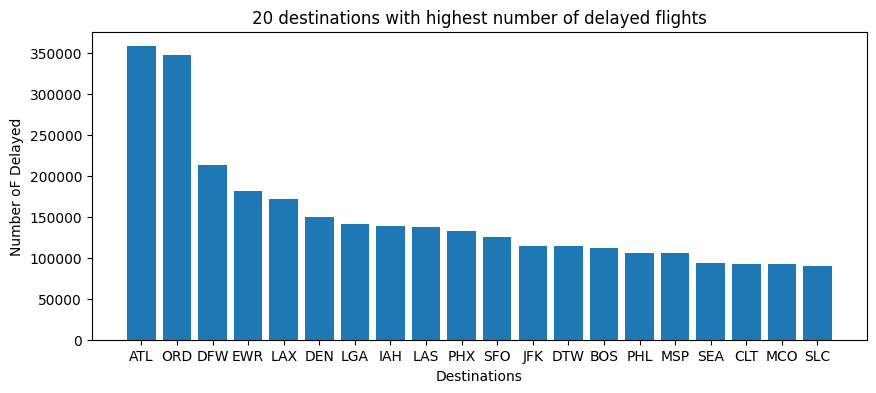

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(top_20_values.select("Dest").rdd.flatMap(lambda x: x).collect(),  top_20_values.select("count").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Destinations")
plt.ylabel("Number oF Delayed")
plt.title("20 destinations with highest number of delayed flights")
plt.show()

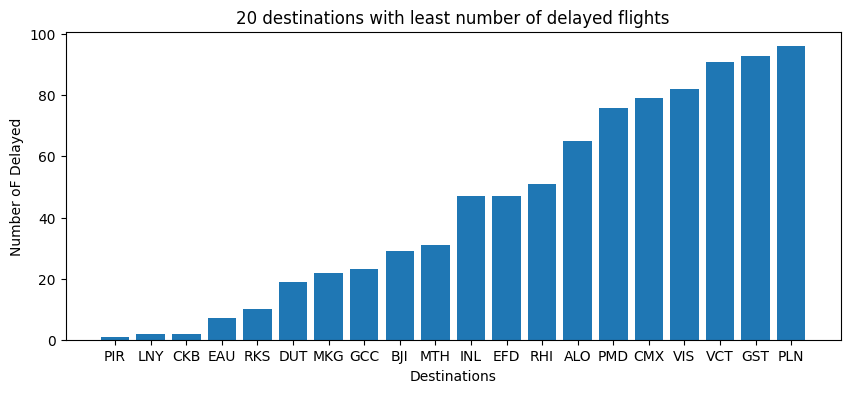

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(bottom_20_values.select("Dest").rdd.flatMap(lambda x: x).collect(),  bottom_20_values.select("count").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Destinations")
plt.ylabel("Number oF Delayed")
plt.title("20 destinations with least number of delayed flights")
plt.show()

CSRElapsedTime

In [ ]:
crse_df, unique_crse, unique_crse_counts = get_unique_counts("CRSElapsedTime", delayed_flights_df)
print(len(unique_crse), len(unique_crse_counts))
crse_df.show(n=10)

588 588
+--------------+------+
|CRSElapsedTime| count|
+--------------+------+
|           148| 20583|
|           496|   115|
|           463|    44|
|           243|  4604|
|           392|   653|
|           540|   114|
|            31|   792|
|           516|   104|
|           137| 21032|
|            85|113862|
+--------------+------+
only showing top 10 rows



In [ ]:
# Calculate the minimum, maximum and average value of the CRSElapsedTime column
min_value = delayed_flights_df.agg(min("CRSElapsedTime")).collect()[0][0]
max_value = delayed_flights_df.agg(max("CRSElapsedTime")).collect()[0][0]
mean_value = delayed_flights_df.agg(avg("CRSElapsedTime")).collect()[0][0]

print("Minimum Value: ", min_value)
print("Maximum Value: ", max_value)
print("Mean Value: ", mean_value)

Minimum Value:  -30
Maximum Value:  660
Mean Value:  131.62116243777785


In [ ]:
bin_size = 50
# Add a new column to the DataFrame with the bin value
df = delayed_flights_df.withColumn("crse_bin", floor(col("CRSElapsedTime") / bin_size) * bin_size)
# Group by the distance bin and calculate the count of occurrences in each bin
bin_counts = df.groupBy("crse_bin").count()
bin_counts = bin_counts.sort(desc("crse_bin"))
bin_counts.show()

+--------+-------+
|crse_bin|  count|
+--------+-------+
|     650|    233|
|     600|    361|
|     550|   1438|
|     500|   4170|
|     450|   5276|
|     400|   6320|
|     350|  64772|
|     300| 141644|
|     250| 215506|
|     200| 386244|
|     150| 932334|
|     100|1635584|
|      50|2169240|
|       0| 129584|
|     -50|      3|
+--------+-------+



In [ ]:
num_bins = bin_counts.count()
print("Number of bins: ", num_bins)
crs_inter = bin_counts.select("crse_bin").rdd.flatMap(lambda x: x).collect()
crs_inter_counts = bin_counts.select("count").rdd.flatMap(lambda x: x).collect()
len(crs_inter), len(crs_inter_counts)

Number of bins:  15


(15, 15)

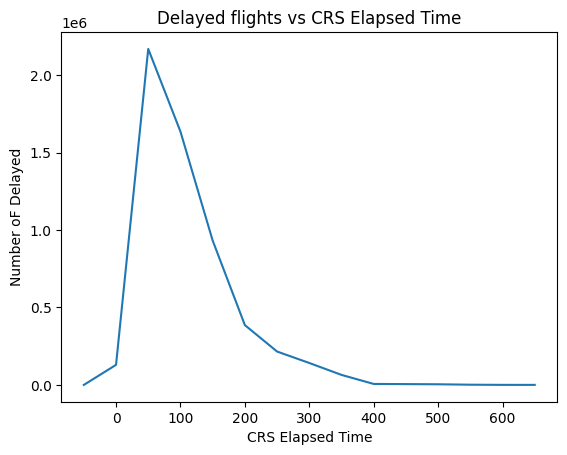

In [ ]:
# plot
plt.plot(crs_inter, crs_inter_counts)
plt.xlabel("CRS Elapsed Time")
plt.ylabel("Number oF Delayed")
plt.title("Delayed flights vs CRS Elapsed Time")
plt.show()

#### Distance

In [ ]:
dist_df, unique_dist, unique_dist_counts = get_unique_counts("Distance", delayed_flights_df)
len(unique_dist), len(unique_dist_counts)

(1479, 1479)

In [ ]:
# Calculate the minimum, maximum, mean values of the Distance column
min_value = delayed_flights_df.agg(min("Distance")).collect()[0][0]
max_value = delayed_flights_df.agg(max("Distance")).collect()[0][0]
mean_value = delayed_flights_df.agg(avg("Distance")).collect()[0][0]
print("Minimum Value: ", min_value)
print("Maximum Value: ", max_value)
print("Mean Value: ", mean_value)

Minimum Value:  11
Maximum Value:  4962
Mean Value:  751.9869557709695


In [ ]:
bin_size = 100
# Add a new column to the DataFrame with the bin value
df = delayed_flights_df.withColumn("distance_bin", floor(col("Distance") / bin_size) * bin_size)
# Group by the distance bin and calculate the count of occurrences in each bin
bin_counts = df.groupBy("distance_bin").count()
bin_counts.show(n=20)

+------------+------+
|distance_bin| count|
+------------+------+
|        3800|   129|
|           0| 73157|
|        2900|  2488|
|        2400| 70373|
|        3200|   399|
|        1200| 95045|
|        2300| 31072|
|        2700|  6546|
|         600|469826|
|         700|333978|
|        4900|   668|
|        1800| 45696|
|        3700|  1330|
|        1100|154459|
|        3300|   835|
|         900|329703|
|        1700| 93327|
|         500|524297|
|        1000|283827|
|        4500|   934|
+------------+------+
only showing top 20 rows



In [ ]:
num_bins = bin_counts.count()
print("Number of bins: ", num_bins)
dist_inter = bin_counts.select("distance_bin").rdd.flatMap(lambda x: x).collect()
dist_inter_counts = bin_counts.select("count").rdd.flatMap(lambda x: x).collect()
len(dist_inter), len(dist_inter_counts)

Number of bins:  43


(43, 43)

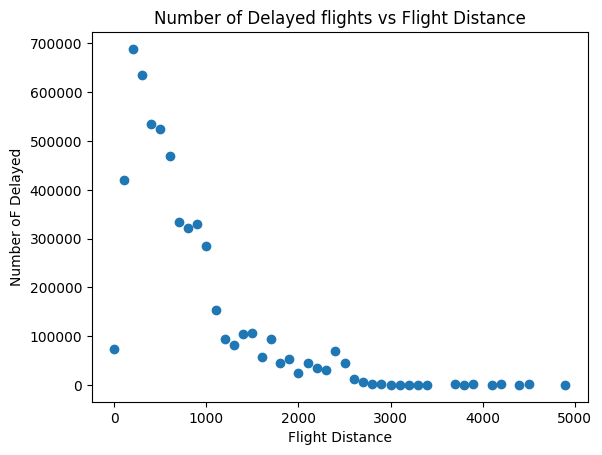

In [ ]:
plt.scatter(dist_inter, dist_inter_counts)
plt.xlabel("Flight Distance")
plt.ylabel("Number oF Delayed")
plt.title("Number of Delayed flights vs Flight Distance")
plt.show()

### Combining multiple variables

In [ ]:
combined_counts = [counts, unique_counts, unique_tailcounts, unique_origin_counts, unique_dest_counts, unique_dist_counts]
data_names = ['UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest',  'Distance']

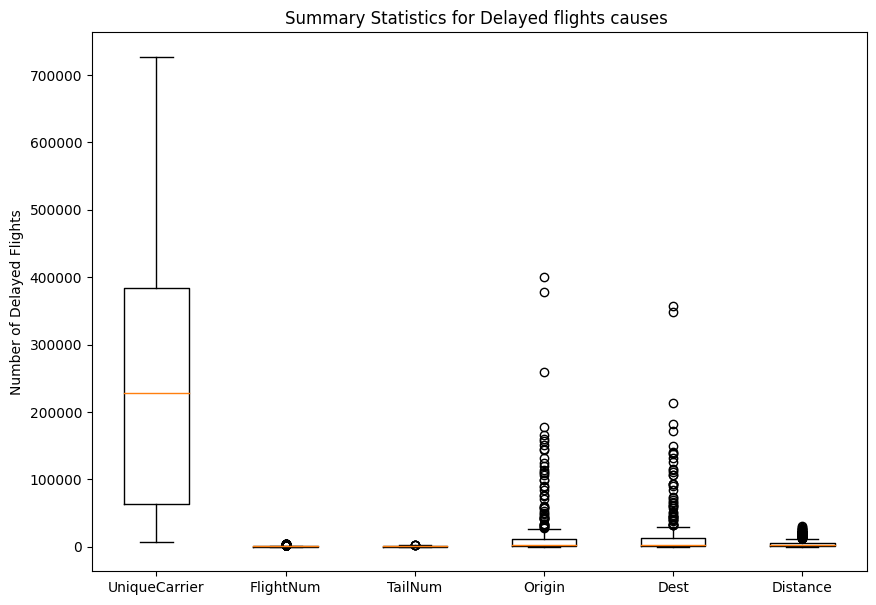

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.boxplot(combined_counts)
ax.set_xticklabels(data_names)
plt.ylabel("Number of Delayed Flights")
plt.title("Summary Statistics for Delayed flights causes ")
plt.show()

### Taxi In 

In [ ]:
delayed_flights_df = flights_df.filter(col("Ontime") == 'false')
on_time_flights_df = flights_df.filter(col("Ontime") == 'true')

In [ ]:
# function to get the  bins 
def binning(main_df, col_name, bin_size=100):
  df = main_df.withColumn("bin", floor(col(col_name) / bin_size) * bin_size)
  bin_counts = df.groupBy("bin").count()
  bin_counts = bin_counts.sort(desc("bin"))
  num_bins = bin_counts.count()
  intervals = bin_counts.select("bin").rdd.flatMap(lambda x: x).collect()
  interval_counts = bin_counts.select("count").rdd.flatMap(lambda x: x).collect()
  interval_counts = bin_counts.select("count").rdd.flatMap(lambda x: x).collect()
  return bin_counts, num_bins, intervals, interval_counts


In [ ]:
# delayed
d_bin_counts, d_num_bins, d_intervals, d_interval_counts = binning(delayed_flights_df, 'TaxiIn', bin_size=100)
print(d_num_bins, len(d_intervals), len(d_interval_counts) )
d_bin_counts.show()

16 16 16
+----+-------+
| bin|  count|
+----+-------+
|1500|      3|
|1400|   7892|
|1300|     83|
|1200|     45|
|1100|     30|
|1000|     18|
| 900|     33|
| 800|     11|
| 700|      9|
| 600|      9|
| 500|     10|
| 400|      9|
| 300|      9|
| 200|     72|
| 100|   1883|
|   0|5682593|
+----+-------+



In [ ]:
# ontime
o_bin_counts, o_num_bins, o_intervals, o_interval_counts = binning(on_time_flights_df, 'TaxiIn', bin_size=100)
print(o_num_bins, len(o_intervals), len(o_interval_counts))
o_bin_counts.show()

15 15 15
+----+--------+
| bin|   count|
+----+--------+
|1400|    2796|
|1300|     106|
|1200|      97|
|1100|      53|
|1000|      37|
| 900|      34|
| 800|      73|
| 700|      54|
| 600|      43|
| 500|      37|
| 400|      42|
| 300|       5|
| 200|       3|
| 100|      45|
|   0|18916333|
+----+--------+



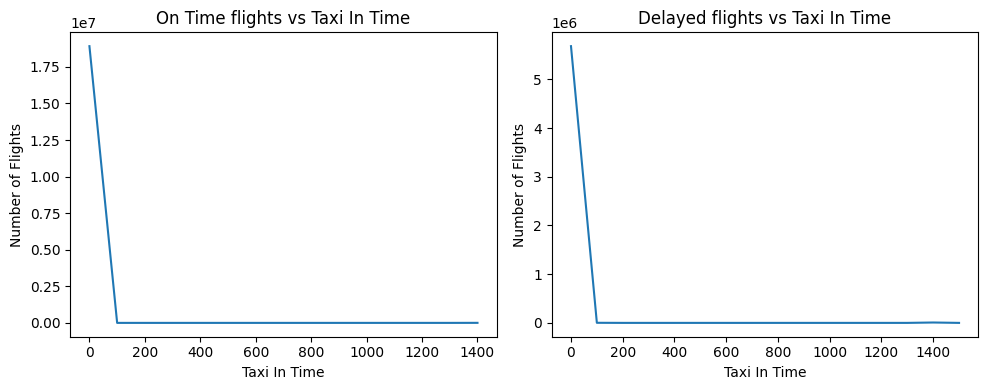

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(o_intervals[:], o_interval_counts[:])
axes[0].set_title("On Time flights vs Taxi In Time")
axes[0].set_xlabel("Taxi In Time")
axes[0].set_ylabel("Number of Flights")

axes[1].plot(d_intervals[:], d_interval_counts[:])
axes[1].set_title("Delayed flights vs Taxi In Time")
axes[1].set_xlabel("Taxi In Time")
axes[1].set_ylabel("Number of Flights")

fig.tight_layout()

### Taxi Out

In [ ]:
#delayed
d_bin_counts, d_num_bins, d_intervals, d_interval_counts = binning(delayed_flights_df, 'TaxiOut', bin_size=100)
print(d_num_bins, len(d_intervals), len(d_interval_counts) )
d_bin_counts.show()

13 13 13
+----+-------+
| bin|  count|
+----+-------+
|1400|     17|
|1300|     21|
|1200|      3|
| 900|      2|
| 800|      3|
| 700|      3|
| 600|      4|
| 500|      3|
| 400|      3|
| 300|    122|
| 200|   2254|
| 100|  47271|
|   0|5643003|
+----+-------+



In [ ]:
#ontime
o_bin_counts, o_num_bins, o_intervals, o_interval_counts = binning(on_time_flights_df, 'TaxiOut', bin_size=100)
print(o_num_bins, len(o_intervals), len(o_interval_counts))
o_bin_counts.show()

14 14 14
+----+--------+
| bin|   count|
+----+--------+
|1400|      13|
|1300|      10|
|1200|       2|
|1000|       2|
| 900|       3|
| 800|       2|
| 700|       2|
| 600|       3|
| 500|       1|
| 400|       5|
| 300|      11|
| 200|      13|
| 100|      75|
|   0|18919616|
+----+--------+



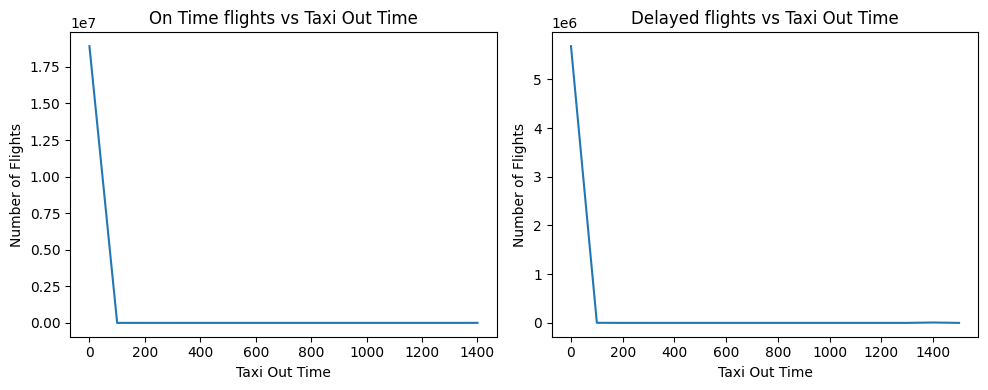

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(o_intervals[:], o_interval_counts[:])
axes[0].set_title("On Time flights vs Taxi Out Time")
axes[0].set_xlabel("Taxi Out Time")
axes[0].set_ylabel("Number of Flights")

axes[1].plot(d_intervals[:], d_interval_counts[:])
axes[1].set_title("Delayed flights vs Taxi Out Time")
axes[1].set_xlabel("Taxi Out Time")
axes[1].set_ylabel("Number of Flights")

fig.tight_layout()

## Investigationg the contribution of each cause of Delay

In [ ]:
# Function to calculate the total delay time for a given column
def calculate_total_delay(column_name):
    """
    Returns:
        Total delay time for the given column
    """
    return delayed_flights_df.select(column_name).agg({"{}".format(column_name): "sum"}).collect()[0][0]


### Overall contribution of each cause

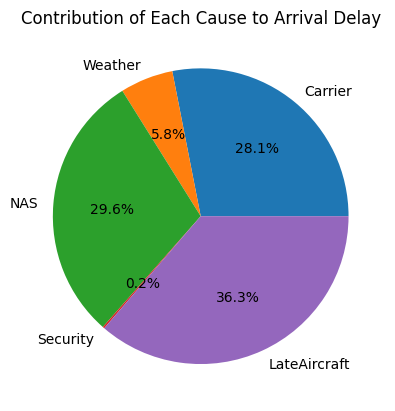

In [ ]:
# List of columns to calculate total delay time
columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# map operation to calculate total delay time for each column
total_delays = list(map(calculate_total_delay, columns))

# pie chart labels
labels = ['Carrier', 'Weather', 'NAS', 'Security', 'LateAircraft']

# pie chart
plt.pie(total_delays, labels=labels, autopct='%1.1f%%')
plt.title("Contribution of Each Cause to Arrival Delay")
plt.show()


### The monthly trend of each cause

<ipython-input-113-461e36c0eacd>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby('Month')['LateAircraftDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay'].sum().plot()


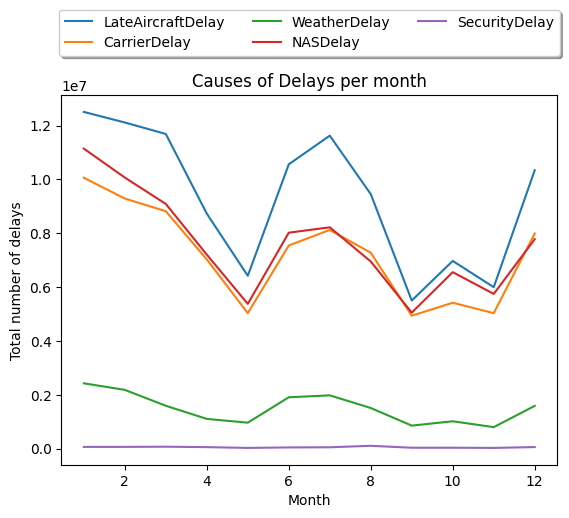

In [ ]:
'''
The code in this cell for the Causes of Delays per month plot was referenced from https://www.kaggle.com/code/adveros/flight-delay-eda-exploratory-data-analysis
'''
# Group the data by month and type of delay and aggregate the total delay time
delayed_monthly = delayed_flights_df.groupBy('Month') \
                       .agg(F.sum('LateAircraftDelay').alias('LateAircraftDelay'),
                            F.sum('CarrierDelay').alias('CarrierDelay'),
                            F.sum('WeatherDelay').alias('WeatherDelay'),
                            F.sum('NASDelay').alias('NASDelay'),
                            F.sum('SecurityDelay').alias('SecurityDelay'))

# spark DataFrame to Pandas for plotting
df_pd = delayed_monthly.toPandas()

df = df_pd.filter(['Month','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'], axis=1)
df = df.groupby('Month')['LateAircraftDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay'].sum().plot()
df.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
plt.title("Causes of Delays per month")
plt.ylabel("Total number of delays")
plt.show()

### Average Per Day Airport Traffic for Each Airport

In [ ]:
# Group by 'Origin' and 'DayOfWeek', and count the number of flights
flights_per_origin_per_day = flights_df.groupBy("Origin", "DayOfWeek").count()

# map function to extract 'Origin' and 'count' columns
def map_func(row):
    return row["Origin"], row["count"]

mapped_rdd = flights_per_origin_per_day.rdd.map(map_func)

# sum the counts for each airport (Origin)
summed_rdd = mapped_rdd.reduceByKey(lambda x, y: x + y)

# calculate the average by dividing the sum by 1461.0 (average number of days in 5 years)
avg_flights_per_origin_per_day = summed_rdd.mapValues(lambda x: int(x / 1461))

# RDD to a DataFrame
avg_flights_per_origin_per_day_df = avg_flights_per_origin_per_day.toDF(["Origin", "avg(count)"])
avg_flights_per_origin_per_day_df.sort(desc("avg(count)")).show()


+------+----------+
|Origin|avg(count)|
+------+----------+
|   ATL|       971|
|   ORD|       829|
|   DFW|       702|
|   LAX|       547|
|   DEN|       510|
|   IAH|       488|
|   PHX|       471|
|   LAS|       419|
|   EWR|       354|
|   SLC|       351|
|   DTW|       348|
|   CVG|       340|
|   MSP|       328|
|   SFO|       311|
|   BOS|       294|
|   MCO|       290|
|   LGA|       285|
|   CLT|       281|
|   PHL|       259|
|   JFK|       259|
+------+----------+
only showing top 20 rows



<ipython-input-115-deaf7d6d6426>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 50, fontsize=6)


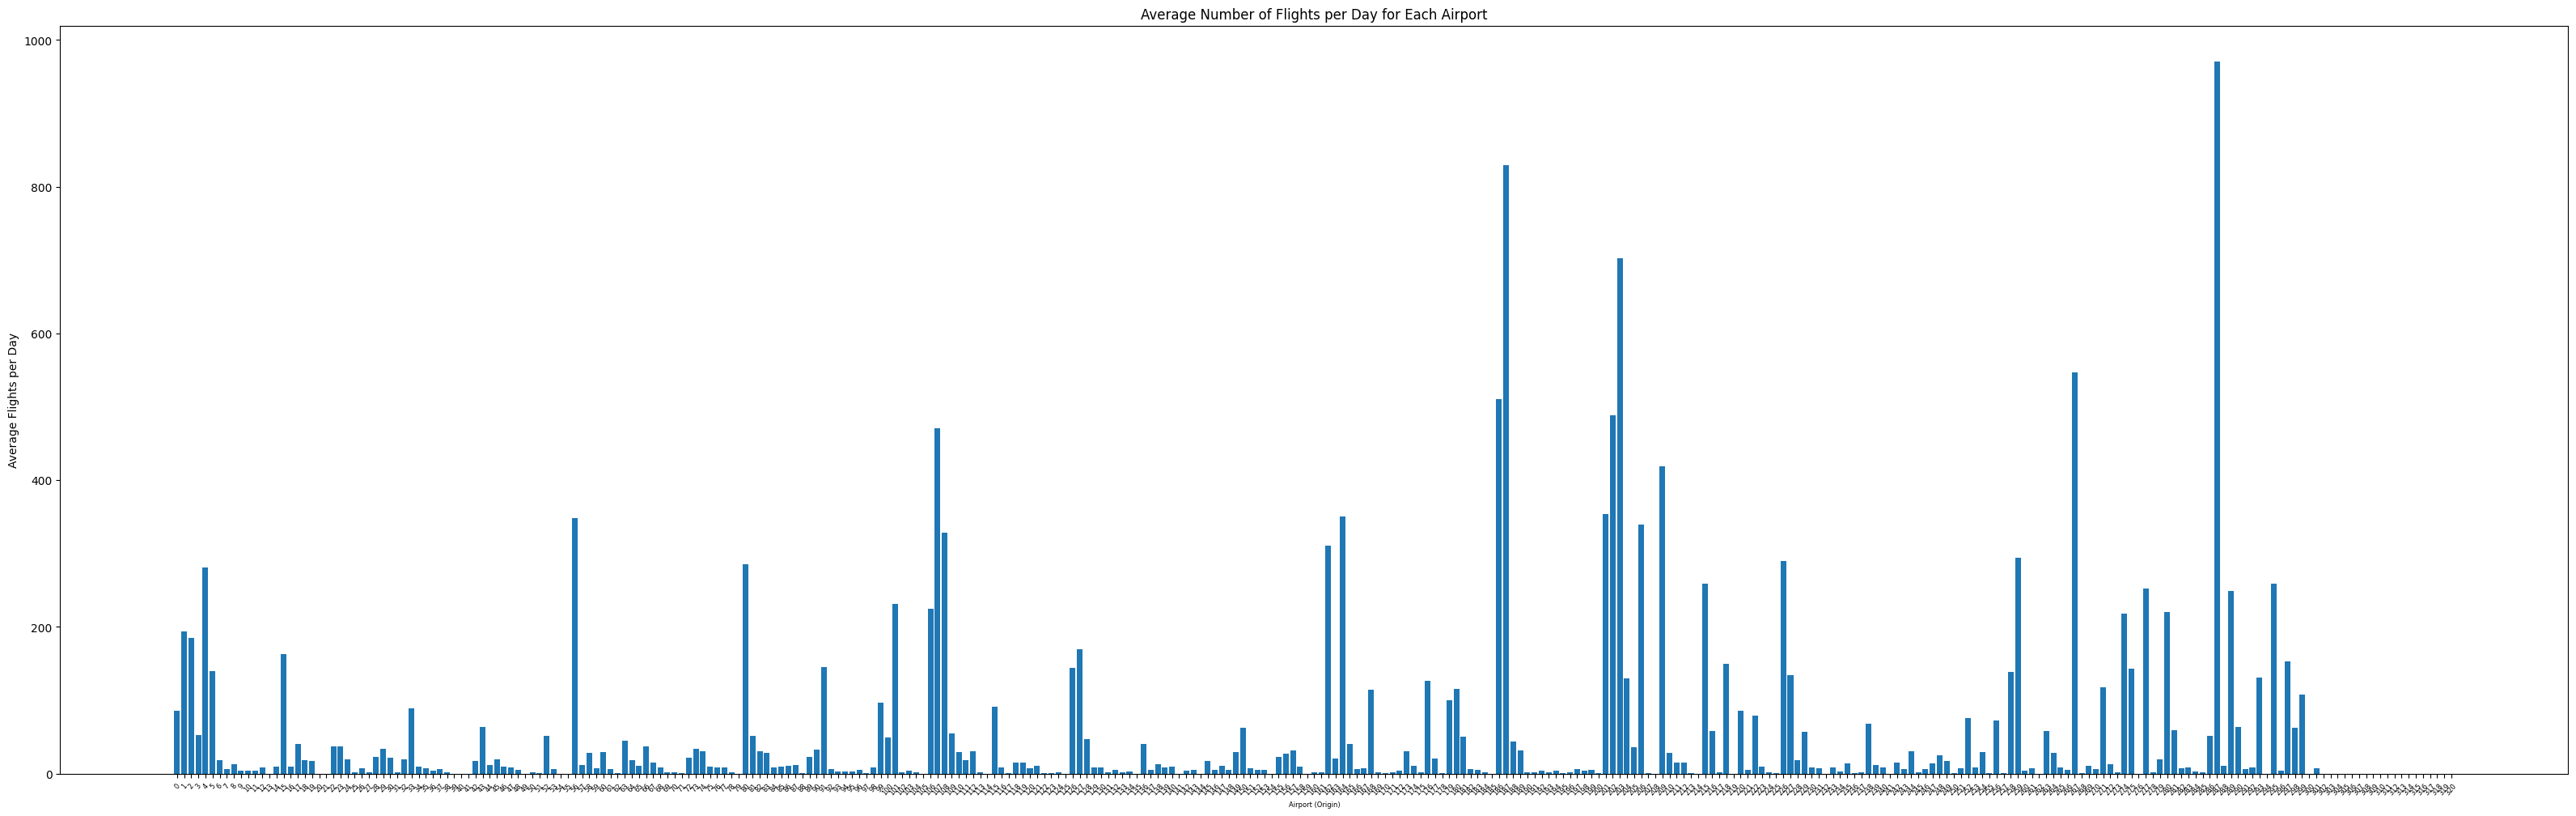

In [ ]:
# Convert the 'avg(count)' column to a list
avg_flights_per_day = avg_flights_per_origin_per_day_df.select("Origin", "avg(count)").collect()

# Extract the 'Origin' and 'avg(count)' values from the list
origin = [row["Origin"] for row in avg_flights_per_day]
avg_count = [row["avg(count)"] for row in avg_flights_per_day]

fig, ax = plt.subplots(figsize=(40, 12))
ax.bar(origin, avg_count)
ax.set_xlabel("Airport (Origin)", fontsize=6)
ax.set_ylabel("Average Flights per Day")
ax.set_title("Average Number of Flights per Day for Each Airport")
ax.set_xticklabels(ax.get_xticks(), rotation = 50, fontsize=6)
plt.show()


In [ ]:
spark.stop()